In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

import pyproj

In [2]:
def correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y, timestep=3600.):
    """ Correct U, V vectors exported in neXtSIM 'Moorings.nc'
    
    Input
    -----
    n_u : 2D array with 'siu' from Moorings.nc
    n_v : 2D array with 'siv' from Moorings.nc
    lon0 : 2D array with 'lon' from barents_eps_*nc
    lat0 : 2D array with 'lat' from barents_eps_*nc
    b_x : 1D array with 'X' from barents_eps_*nc
    b_y : 1D array with 'Y' from barents_eps_*nc
    
    Returns
    -------
    b_u : 2D array with X component (U) of ice velocity in barents_eps_*nc coordinates
    b_v : 2D array with Y component (V) of ice velocity in barents_eps_*nc coordinates
    """
    nextsim_proj = pyproj.Proj('+proj=stere +a=6378273.0 +b=6356889.448910593 +lon_0=-45.0 +lat_0=90.0 +lat_ts=60.0 +type=crs')
    barents_proj = pyproj.Proj('+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06')

    bx0_n, by0_n = nextsim_proj(lon0, lat0)
    
    bx1_n = bx0_n + n_u * timestep
    by1_n = by0_n + n_v * timestep

    lon1, lat1 = nextsim_proj(bx1_n, by1_n, inverse=True)
    bx1, by1 = barents_proj(lon1, lat1)
    bx0, by0 = np.meshgrid(b_x, b_y)
    
    b_u = (bx1 - bx0) / timestep
    b_v = (by1 - by0) / timestep
    b_u.mask = n_u.mask
    b_v.mask = n_v.mask

    return b_u, b_v


In [3]:
nov22_date = 19 #19th Nov 2022
m_idx = int((nov22_date - 1)*24) 
m2name = '/home/jovyan/data/NERSC_model_data/NERSC_modelMoorings_barents.nc'
with Dataset(m2name) as ds:
    n_u1 = ds['siu']
    n_u = ds['siu'][m_idx]
    n_v = ds['siv'][m_idx]

In [4]:
with Dataset('https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20221119T00Z.nc') as ds:
    b_x = ds['X'][:]
    b_y = ds['Y'][:]    
    lon0 = ds['lon'][:]
    lat0 = ds['lat'][:]
    # OPTIONAL:
    ice_u = ds['ice_u'][0,0]
    ice_v = ds['ice_v'][0,0]


In [5]:
b_u, b_v = correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y)    

In [170]:
%store -r ice_u_corrected
%store -r ice_v_corrected

#Import variables for extracting subsets from SAR1-SAR2_drift.ipynb
%store -r r
%store -r c
%store -r X_subset
%store -r Y_subset
%store -r lon_subset
%store -r lat_subset

In [7]:
ice_u_corrected.shape

(26, 949, 739)

In [217]:
%store -r int_dx
%store -r int_dy
%store -r xx
%store -r yy
%store -r int_dx_b
%store -r int_dy_b


In [127]:
int_dx[0][339976], int_dx_b[0][339976]

(26.83308931957775, 193.1642303466797)

In [221]:
lists_to_reshape = [int_dx, int_dy]#, int_dx_b, int_dy_b, xx, yy]

for my_list in lists_to_reshape:
    for i, disp in enumerate(my_list):
        disp_reshaped = disp.reshape(((154, 160))) #((949, 739))
        my_list[i] = disp_reshaped


In [167]:
# Iterate over each array in int_dx and int_dy lists
for i in range(len(int_dx)):
    int_dx[i][np.isinf(int_dx[i])] = np.nan
    int_dy[i][np.isinf(int_dy[i])] = np.nan
    int_dx_b[i][np.isinf(int_dx[i])] = np.nan
    int_dy_b[i][np.isinf(int_dy[i])] = np.nan


In [92]:
# Check if there are any inf values in int_dx[0]
has_inf = np.any(np.isinf(int_dy[0]))

# Print the result
if has_inf:
    print("int_dx[0] still contains inf values.")
else:
    print("No inf values found in int_dx[0].")

No inf values found in int_dx[0].


In [93]:
%store -r total_time_diff
total_time_diff

88851

In [152]:
# Divide values in the first list by 2272
int_dx[0] /= 2272
int_dy[0] /= 2272

# Divide values in the middle lists by 3600
for i in range(1, len(int_dx)-1):
    int_dx[i] /= (2272 + i*3600)
    int_dy[i] /= (2272 + i*3600)

# Divide values in the last list by 179
int_dx[-1] /= total_time_diff
int_dy[-1] /= total_time_diff


In [106]:
int_dx[25][460][0]

2.1135903262084036e-14

In [149]:
# Divide values in the first list by 2272
int_dx_b[0] /= 2272
int_dy_b[0] /= 2272

# Divide values in the middle lists by 3600
for i in range(1, len(int_dx)-1):
    int_dx_b[i] /= (2272 + i*3600)
    int_dy_b[i] /= (2272 + i*3600)

# Divide values in the last list by 179
int_dx_b[-1] /= total_time_diff
int_dy_b[-1] /= total_time_diff


In [192]:
%store -r upm
%store -r vpm
%store -r gpi
%store -r x1pm
%store -r y1pm

In [194]:
upm.shape

(154, 160)

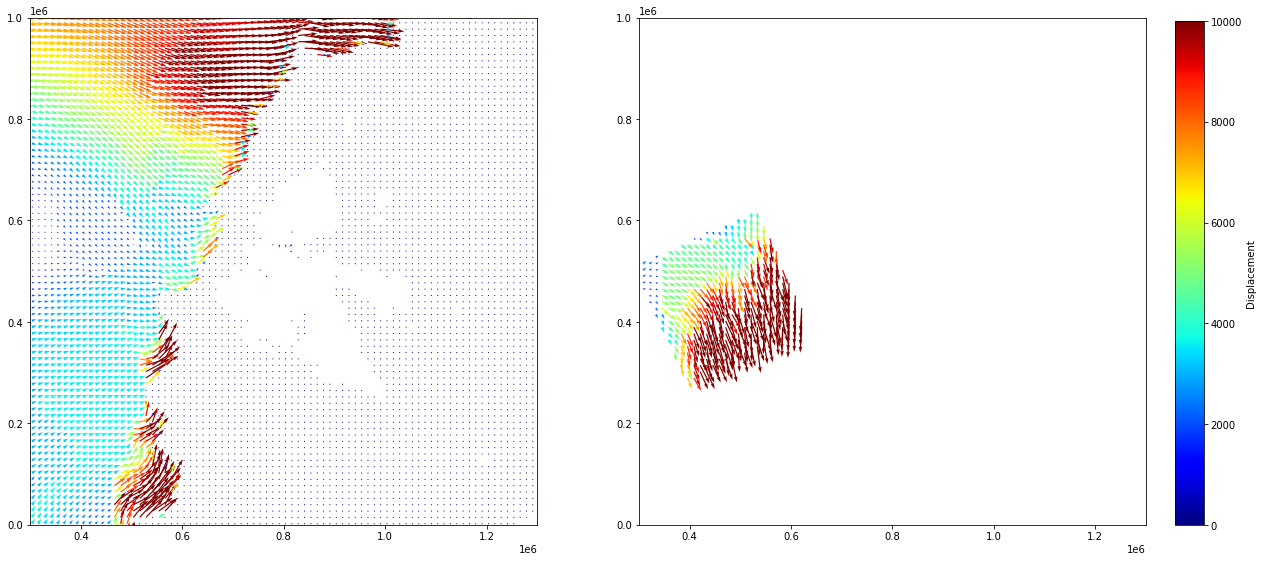

In [198]:
#Integrated drift
#Change fron ens 8 to 24 mean!
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
quiver1 = axs[0].quiver(b_x[::step], b_y[::step], int_dx[-1][::step, ::step], int_dy[-1][::step, ::step], np.hypot(int_dx[-1][::step, ::step], int_dy[-1][::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')
axs[1].quiver(X_subset[::step], Y_subset[::step], upm[::step, ::step], vpm[::step, ::step], np.hypot(upm[::step, ::step], vpm[::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

plt.show()

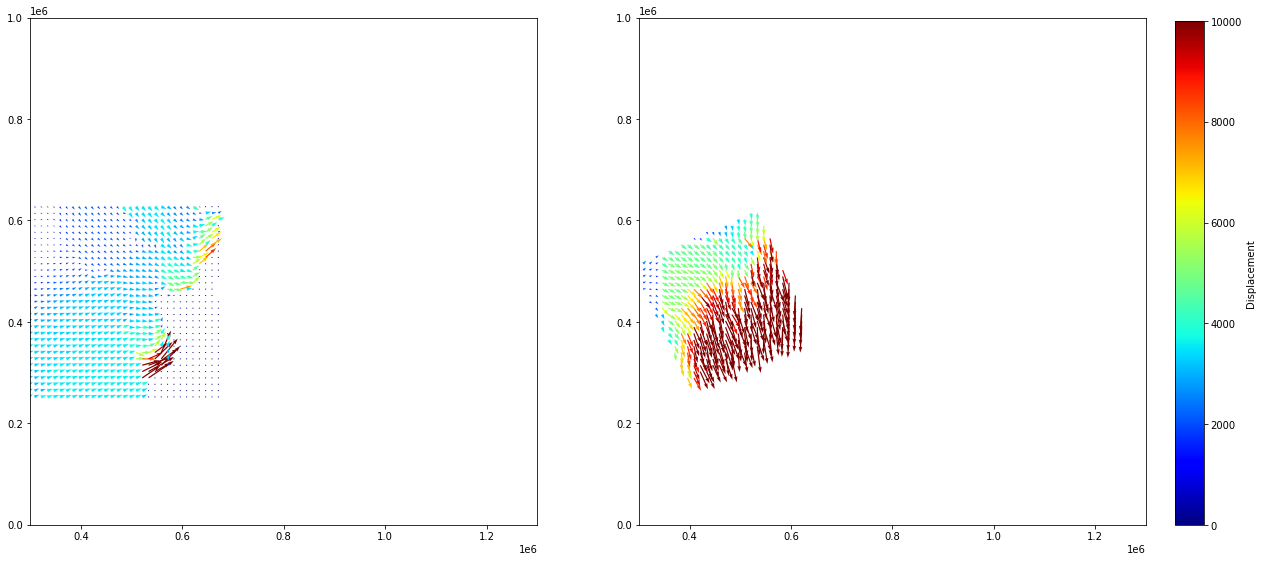

In [237]:
#Integrated drift
#Change fron ens 8 to 24 mean!
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
quiver1 = axs[0].quiver(X_subset[::step], Y_subset[::step], int_dx[-1][::step, ::step], int_dy[-1][::step, ::step], np.hypot(int_dx[-1][::step, ::step], int_dy[-1][::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')
quiver2 = axs[1].quiver(X_subset[::step], Y_subset[::step], upm[::step, ::step], vpm[::step, ::step], np.hypot(upm[::step, ::step], vpm[::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

plt.show()

In [ ]:
#Integrated drift
#Change fron ens 8 to 24 mean!
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
quiver1 = axs[0].quiver(X_subset[::step], Y_subset[::step], int_dx[-1][::step, ::step], int_dy[-1][::step, ::step], np.hypot(int_dx[-1][::step, ::step], int_dy[-1][::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')
axs[1].quiver(X_subset[::step], Y_subset[::step], upm[::step, ::step], vpm[::step, ::step], np.hypot(upm[::step, ::step], vpm[::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

plt.show()

In [202]:
X_sub_mesh, Y_sub_mesh = np.meshgrid(X_subset, Y_subset)

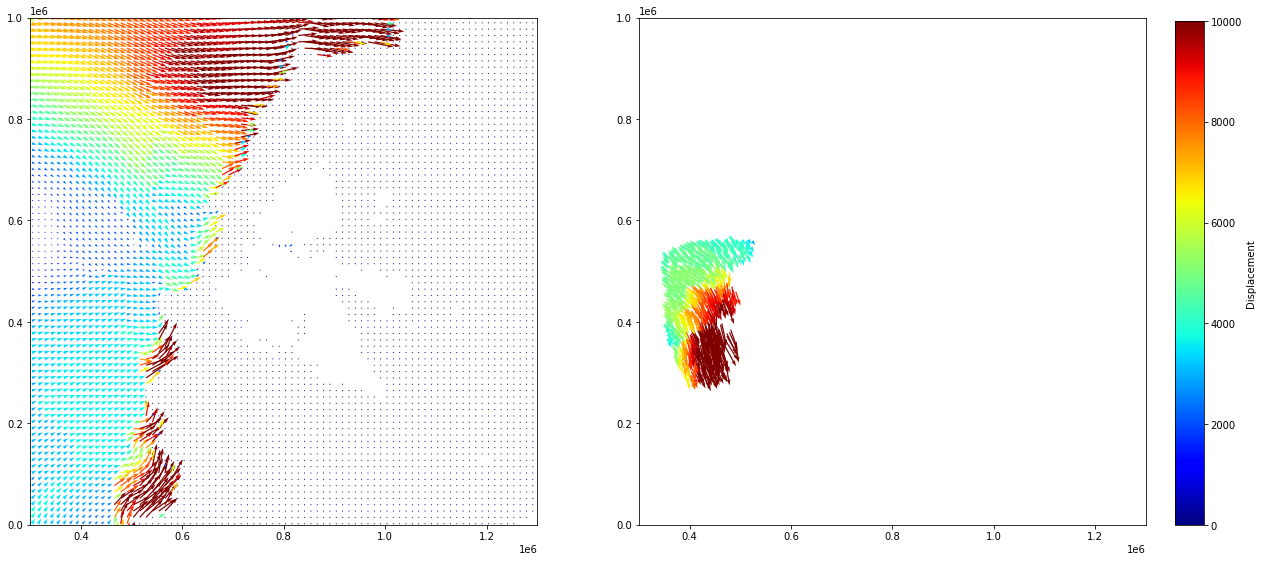

In [203]:
#Integrated drift
#Change fron ens 8 to 24 mean!
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
quiver1 = axs[0].quiver(b_x[::step], b_y[::step], int_dx[-1][::step, ::step], int_dy[-1][::step, ::step], np.hypot(int_dx[-1][::step, ::step], int_dy[-1][::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')
axs[1].quiver(X_sub_mesh[gpi][::step], Y_sub_mesh[gpi][::step], upm[gpi][::step], vpm[gpi][::step], np.hypot(upm[gpi][::step], vpm[gpi][::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

plt.show()

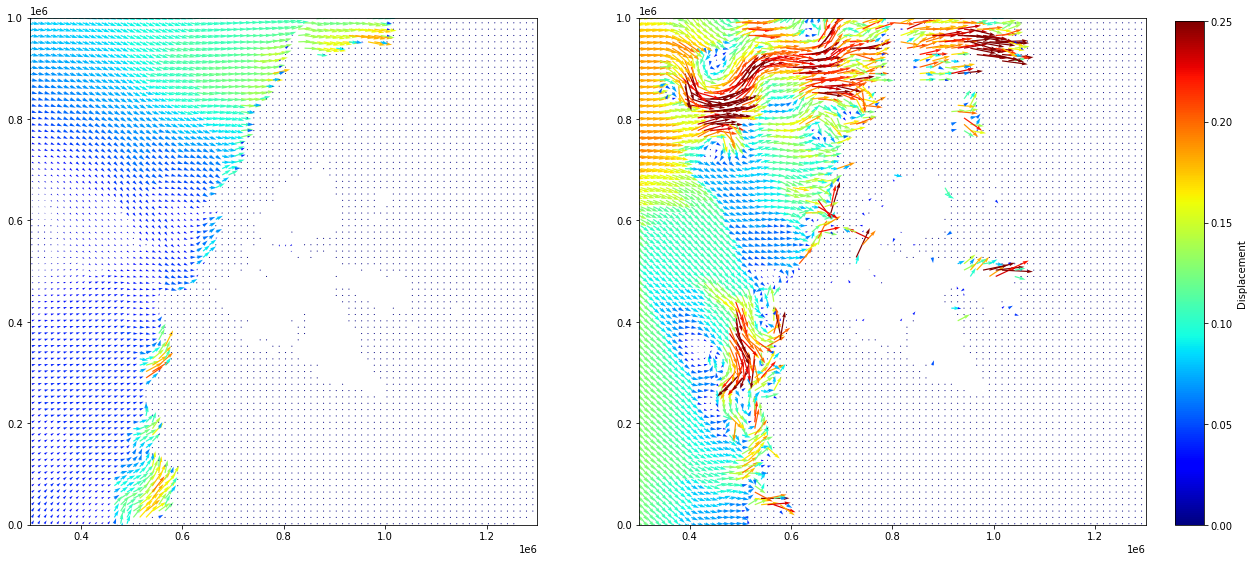

In [160]:
#Integrated drift
#Change fron ens 8 to 24 mean!
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
quiver1 = axs[0].quiver(b_x[::step], b_y[::step], int_dx[-1][::step, ::step], int_dy[-1][::step, ::step], np.hypot(int_dx[-1][::step, ::step], int_dy[-1][::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.25])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], int_dx_b[-1][::step, ::step], int_dy_b[-1][::step, ::step], np.hypot(int_dx_b[-1][::step, ::step], int_dy_b[-1][::step, ::step]), angles='xy', scale_units='xy', scale=0.000005 , cmap='jet', clim=[0, 0.25])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

plt.show()

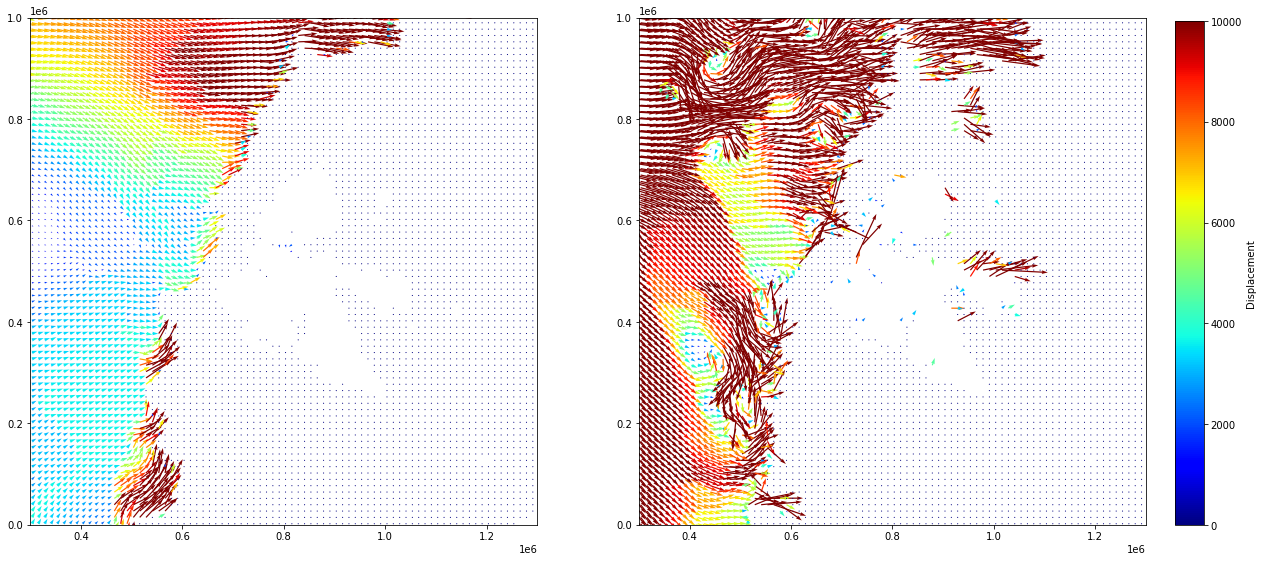

In [148]:
#Integrated drift
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
quiver1 = axs[0].quiver(b_x[::step], b_y[::step], int_dx[25][::step, ::step], int_dy[25][::step, ::step], np.hypot(int_dx[25][::step, ::step], int_dy[25][::step, ::step]), angles='xy', scale_units='xy', scale=0.3, cmap='jet', clim=[0, 10000])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], int_dx_b[25][::step, ::step], int_dy_b[25][::step, ::step], np.hypot(int_dx_b[25][::step, ::step], int_dy_b[25][::step, ::step]), angles='xy', scale_units='xy', scale=0.3 , cmap='jet', clim=[0,10000])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

plt.show()

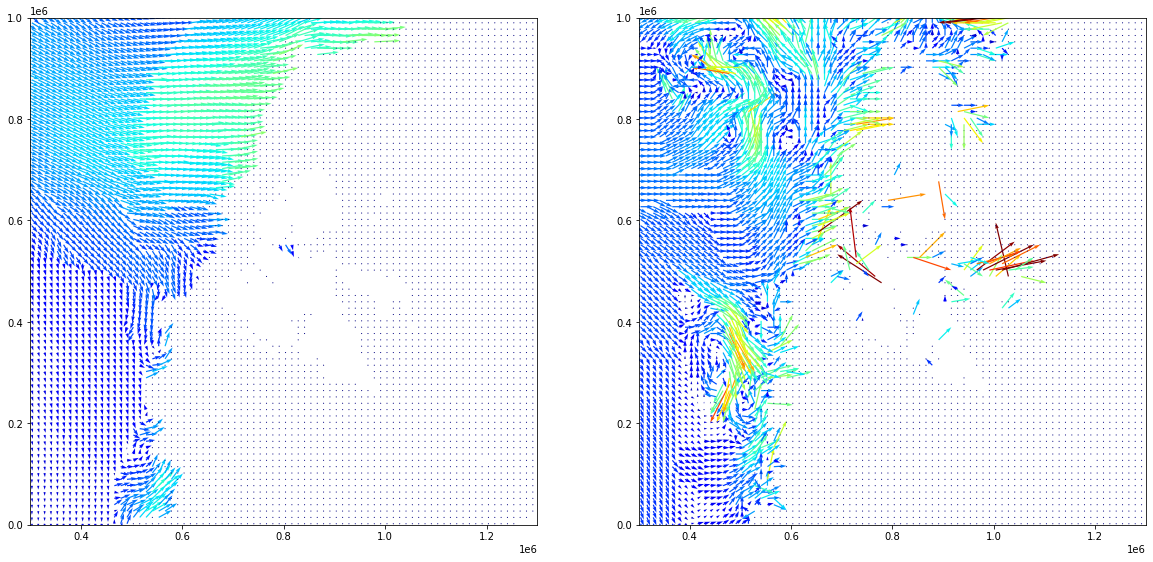

In [13]:
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].quiver(b_x[::step], b_y[::step], ice_u_corrected[0][::step, ::step], ice_v_corrected[0][::step, ::step], np.hypot(ice_u_corrected[0][::step, ::step], ice_v_corrected[0][::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], ice_u[::step, ::step], ice_v[::step, ::step], np.hypot(ice_u[::step, ::step], ice_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

plt.show()

ValueError: X and Y must be the same size, but X.size is 32 and Y.size is 31.

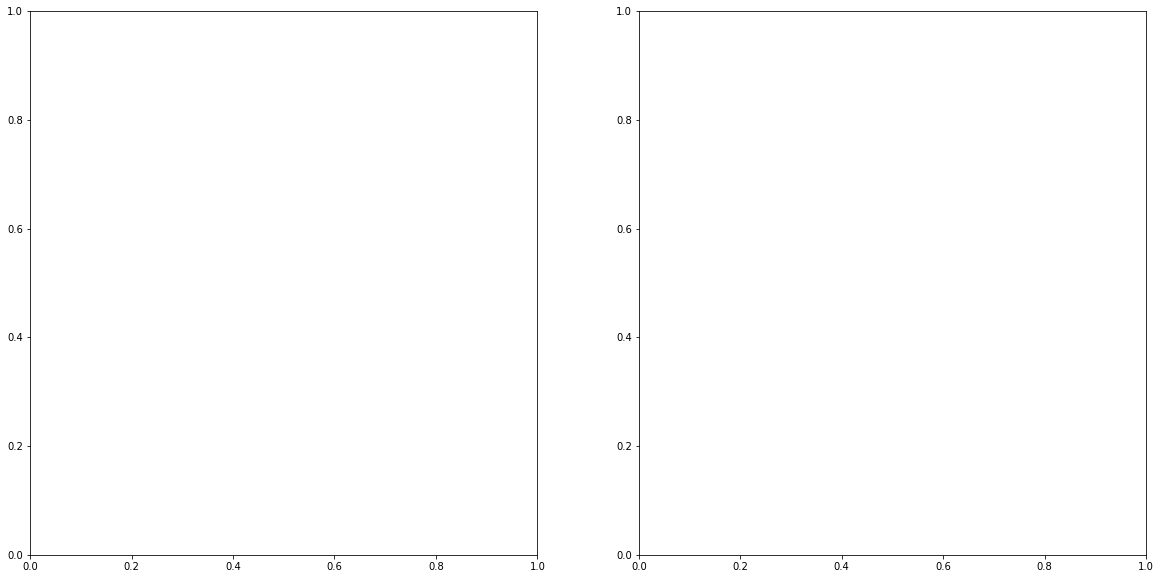

In [ ]:
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].quiver(X_subset[::step], Y_subset[::step], ice_u_corrected[0][::step, ::step], ice_v_corrected[0][::step, ::step], np.hypot(ice_u_corrected[0][::step, ::step], ice_v_corrected[0][::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], ice_u[::step, ::step], ice_v[::step, ::step], np.hypot(ice_u[::step, ::step], ice_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

plt.show()

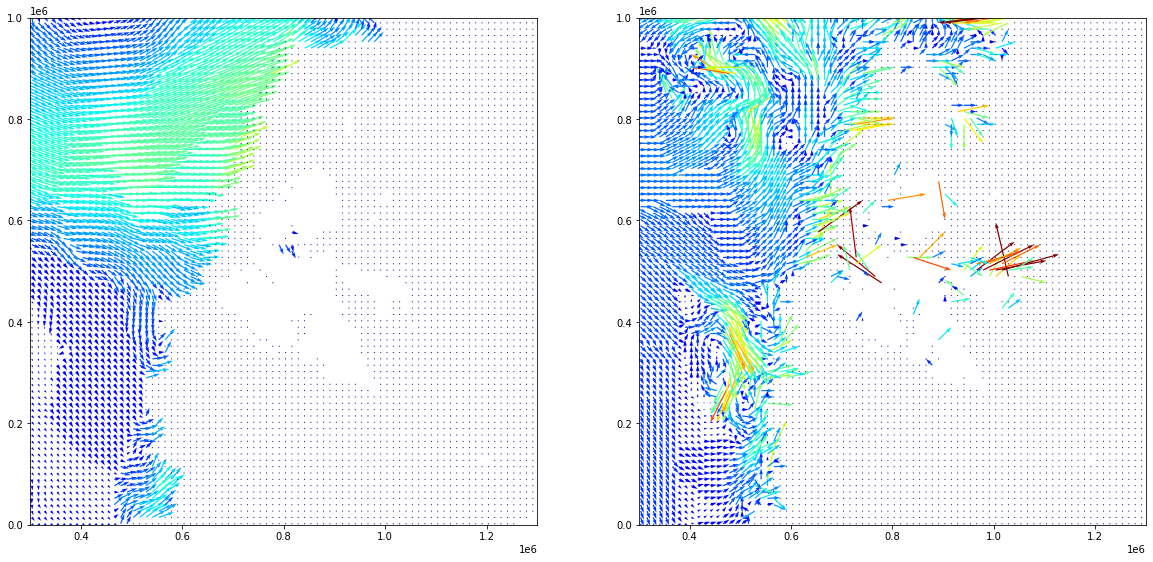

In [31]:
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].quiver(b_x[::step], b_y[::step], b_u[::step, ::step], b_v[::step, ::step], np.hypot(b_u[::step, ::step], b_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], ice_u[::step, ::step], ice_v[::step, ::step], np.hypot(ice_u[::step, ::step], ice_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

plt.show()

In [146]:
speed_model_b = np.sqrt((ice_u**2+ice_v**2)) 

speed_model_n = np.sqrt((ice_u_corrected[25].data**2+ice_v_corrected[25].data**2))

In [147]:
speed_model_b = speed_model_b.flatten()
speed_model_n = speed_model_n.flatten()
speed_model_b.shape,speed_model_n.shape 

((701311,), (701311,))

In [148]:
speed_model_n = speed_model_n[~np.isinf(speed_model_n)]

In [149]:
#speed_model_n = speed_model_n[~np.any(np.isinf(speed_model_n), axis=1), :]
speed_model_b.shape, speed_model_n.shape

((701311,), (461315,))

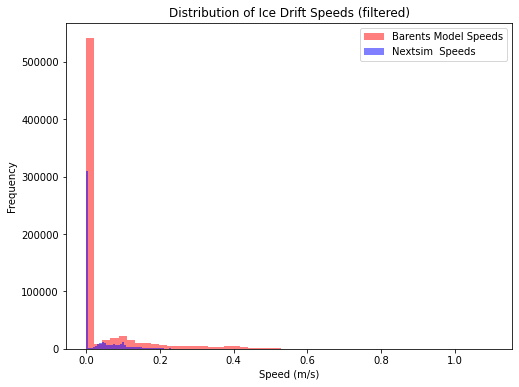

Reference Speeds:
Mean speed: 0.0493 m/s
Min speed: 0.0000 m/s
Max speed: 1.1003 m/s
95th percentile speed: 0.2772 m/s

Model Speeds:
Mean speed: 0.0493 m/s
Min speed: 0.0000 m/s
Max speed: 1.1003 m/s
95th percentile speed: 0.2772 m/s


In [150]:
plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(speed_model_n, bins=50, color='blue', alpha=0.5, label='Nextsim  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_model_b, 95)
mean_speed_ref = np.nanmean(speed_model_b)
min_speed_ref = np.nanmin(speed_model_b)
max_speed_ref = np.nanmax(speed_model_b)

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model_b, 95)
mean_speed_model = np.nanmean(speed_model_b)
min_speed_model = np.nanmin(speed_model_b)
max_speed_model = np.nanmax(speed_model_b)

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


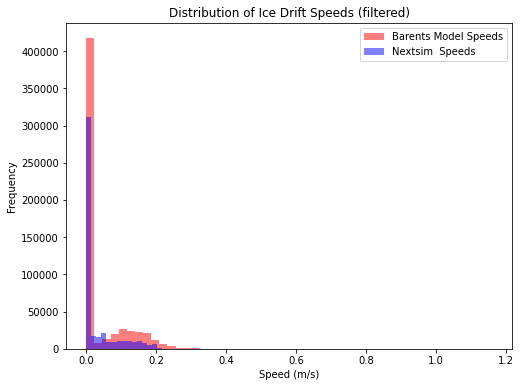

Reference Speeds:
Mean speed: 0.0373 m/s
Min speed: 0.0000 m/s
Max speed: 1.1602 m/s
95th percentile speed: nan m/s

Model Speeds:
Mean speed: 0.0373 m/s
Min speed: 0.0000 m/s
Max speed: 1.1602 m/s
95th percentile speed: nan m/s


In [163]:
speed_model_b = np.sqrt(( int_dx_b[-1]**2+ int_dy_b[-1]**2)) 
speed_model_n = np.sqrt((int_dx[-1]**2+int_dx[-1]**2))

speed_model_b = speed_model_b.flatten()
speed_model_n = speed_model_n.flatten()


plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(speed_model_n, bins=50, color='blue', alpha=0.5, label='Nextsim  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_model_b, 95)
mean_speed_ref = np.nanmean(speed_model_b)
min_speed_ref = np.nanmin(speed_model_b)
max_speed_ref = np.nanmax(speed_model_b)

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model_b, 95)
mean_speed_model = np.nanmean(speed_model_b)
min_speed_model = np.nanmin(speed_model_b)
max_speed_model = np.nanmax(speed_model_b)

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


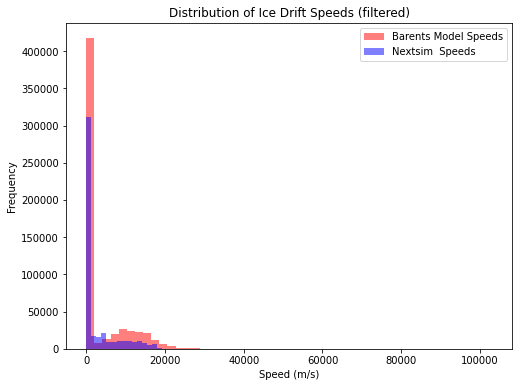

Reference Speeds:
Mean speed: 3310.8077 m/s
Min speed: 0.0000 m/s
Max speed: 103085.5450 m/s
95th percentile speed: nan m/s

Model Speeds:
Mean speed: 3310.8077 m/s
Min speed: 0.0000 m/s
Max speed: 103085.5450 m/s
95th percentile speed: nan m/s


In [169]:
speed_model_b = np.sqrt(( int_dx_b[-1]**2+ int_dy_b[-1]**2)) 
speed_model_n = np.sqrt((int_dx[-1]**2+int_dx[-1]**2))

speed_model_b = speed_model_b.flatten()
speed_model_n = speed_model_n.flatten()


plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(speed_model_n, bins=50, color='blue', alpha=0.5, label='Nextsim  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_model_b, 95)
mean_speed_ref = np.nanmean(speed_model_b)
min_speed_ref = np.nanmin(speed_model_b)
max_speed_ref = np.nanmax(speed_model_b)

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model_b, 95)
mean_speed_model = np.nanmean(speed_model_b)
min_speed_model = np.nanmin(speed_model_b)
max_speed_model = np.nanmax(speed_model_b)

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


In [232]:
speed_model_b.shape, speed_model_n.shape

((24640,), (24640,))

In [236]:
speed_model_b.shape, speed_model_n.shape

((4043,), (4043,))

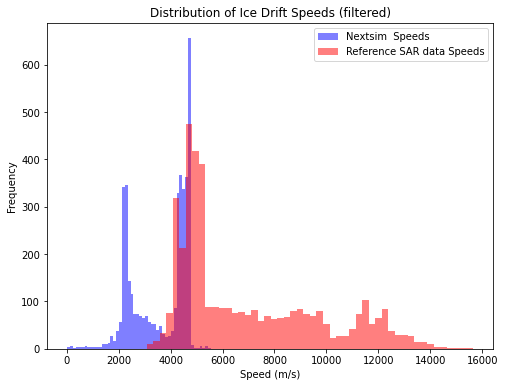

Reference Speeds:
Mean speed: 6932.7848 m/s
Min speed: 3080.6269 m/s
Max speed: 15655.2723 m/s
95th percentile speed: 12337.5081 m/s

Model Speeds:
Mean speed: 6932.7848 m/s
Min speed: 3080.6269 m/s
Max speed: 15655.2723 m/s
95th percentile speed: 12337.5081 m/s


In [235]:
speed_model_b = np.sqrt(( upm[gpi]**2+ vpm[gpi]**2)) 
speed_model_n = np.sqrt((int_dx[-1][gpi]**2+int_dx[-1][gpi]**2))
#speed_model_b = np.sqrt(( upm**2+ vpm**2)) 
#speed_model_n = np.sqrt((int_dx[-1]**2+int_dx[-1]**2))

speed_model_b = speed_model_b.flatten()
speed_model_n = speed_model_n.flatten()


plt.figure(figsize=(8,6))




# Plotting Reference Speed
#speed_model_n_clipped = np.clip(speed_model_n, 1000, 60000)
plt.hist(speed_model_n, bins=50, color='blue', alpha=0.5, label='Nextsim  Speeds')


# Plotting Model Speed
plt.hist(speed_model_b, bins=50, color='red', alpha=0.5, label= 'Reference SAR data Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_model_b, 95)
mean_speed_ref = np.nanmean(speed_model_b)
min_speed_ref = np.nanmin(speed_model_b)
max_speed_ref = np.nanmax(speed_model_b)

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model_b, 95)
mean_speed_model = np.nanmean(speed_model_b)
min_speed_model = np.nanmin(speed_model_b)
max_speed_model = np.nanmax(speed_model_b)

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


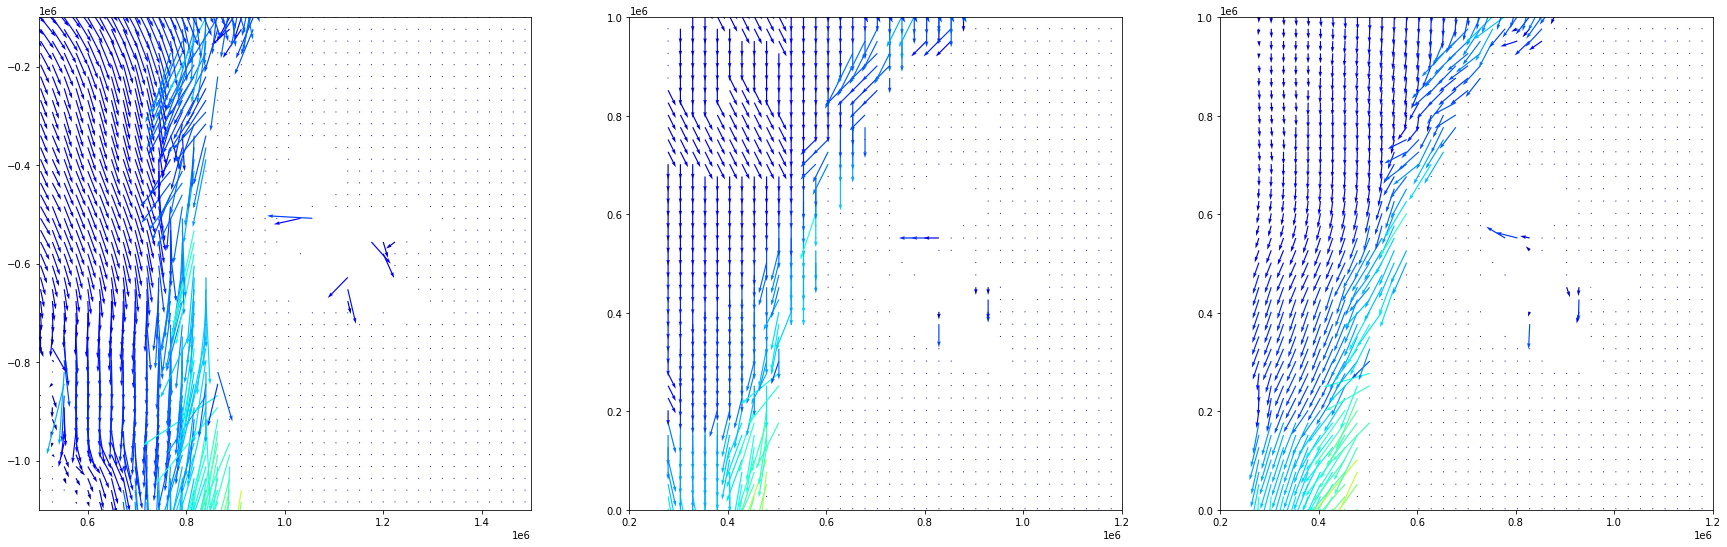

In [7]:
# JUST FOR COMPARISON WITH ANOTHER GRID

with Dataset('/data1/antonk/tmp/Moorings_barents.nc') as ds:
    n_u = ds['siu'][23]
    n_v = ds['siv'][23]

with Dataset('/data1/antonk/tmp/Moorings_2022d305.nc') as ds:
    t_u = ds['siu'][47]
    t_v = ds['siv'][47]

with Dataset('/Data/sim/data/nextsim_output_grids/topaz6_grid.nc') as ds:
    t_x = ds['x'][:] * 100000
    t_y = ds['y'][:] * 100000

b_u, b_v = correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y)    
    
fig, axs = plt.subplots(1,3,figsize=(30,10))
step = 8
#axs[0].pcolormesh(m1x[::step], m1y[::step], , cmap='jet', vmin=0, vmax=0.1)
axs[0].quiver(t_x[::step], t_y[::step], t_u[::step, ::step], t_v[::step, ::step], np.hypot(t_u[::step, ::step], t_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000001, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.5e6,1.5e6])
axs[0].set_ylim([-1.1e6,-0.1e6])
axs[0].set_aspect('equal')

step = 10
#axs[1].pcolormesh(m2x[::step], m2y[::step],  cmap='jet', vmin=0, vmax=0.1)
axs[1].quiver(b_x[::step], b_y[::step], n_u[::step, ::step], n_v[::step, ::step], np.hypot(n_u[::step, ::step], n_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000002, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.2e6,1.2e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

#axs[2].pcolormesh(m2x[::step], m2y[::step], cmap='jet', vmin=0, vmax=0.1)
axs[2].quiver(b_x[::step], b_y[::step], b_u[::step, ::step], b_v[::step, ::step], np.hypot(b_u[::step, ::step], b_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000002, cmap='jet', clim=[0, 0.5])
axs[2].set_xlim([0.2e6,1.2e6])
axs[2].set_ylim([0,1e6])
axs[2].set_aspect('equal')

plt.show()